In [18]:
"""
# Time Series Analysis of Patient Vital Signs

This notebook explores time series forecasting techniques for vital sign prediction,
focusing on heart rate patterns and trends.

1. Data Preparation
   - Load preprocessed data from previous analyses
   - Temporal aggregation and resampling
   - Handle missing values and irregularities

2. Time Series Feature Engineering
   - Create temporal features
   - Handle seasonality and trends
   - Aggregate at appropriate intervals

3. Model Development
   - ARIMA modeling for baseline
   - Prophet for complex patterns
   - Ensemble approaches for robustness

4. Evaluation & Analysis
   - Assess forecast accuracy
   - Analyze prediction intervals
   - Cross-validate temporal predictions

The goal is to develop reliable forecasting models for vital signs,
enabling early warning systems and trend analysis.
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
from datetime import datetime
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from prophet import Prophet

from sklearn.ensemble import (
    RandomForestRegressor,
    IsolationForest,
    GradientBoostingRegressor,
    StackingRegressor  # For stacked model analysis
)
from sklearn.linear_model import (
    LassoCV,
    RidgeCV,
    LinearRegression
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    make_scorer
)
from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    KFold
)
from sklearn.svm import (
    OneClassSVM,
    SVR
)

from setup_utils import load_intermediate_data, plr, save_intermediate_data, plot_forecast

In [4]:
"""
Data Preparation and Temporal Processing
------------------------------------
1. Load preprocessed dataset
2. Filter for specific subject analysis
3. Configure temporal parameters
4. Resample and interpolate time series

Key preprocessing steps:
- Daily aggregation for stable patterns
- Linear interpolation for gaps
- Proper datetime indexing
"""

# Load and prepare data
df = load_intermediate_data('data/intermediate_unsupervised.csv')

# Configure subject-specific analysis
subject_id = 10055235
metric = 'heart_rate'
subject_df = df[df['subject_id'] == subject_id].copy()
subject_df['charttime'] = pd.to_datetime(subject_df['charttime'])

# Ensure proper frequency and handle missing values
subject_df = subject_df.sort_values('charttime')
subject_df.set_index('charttime', inplace=True)
subject_daily = subject_df[metric].resample('D').mean().interpolate()

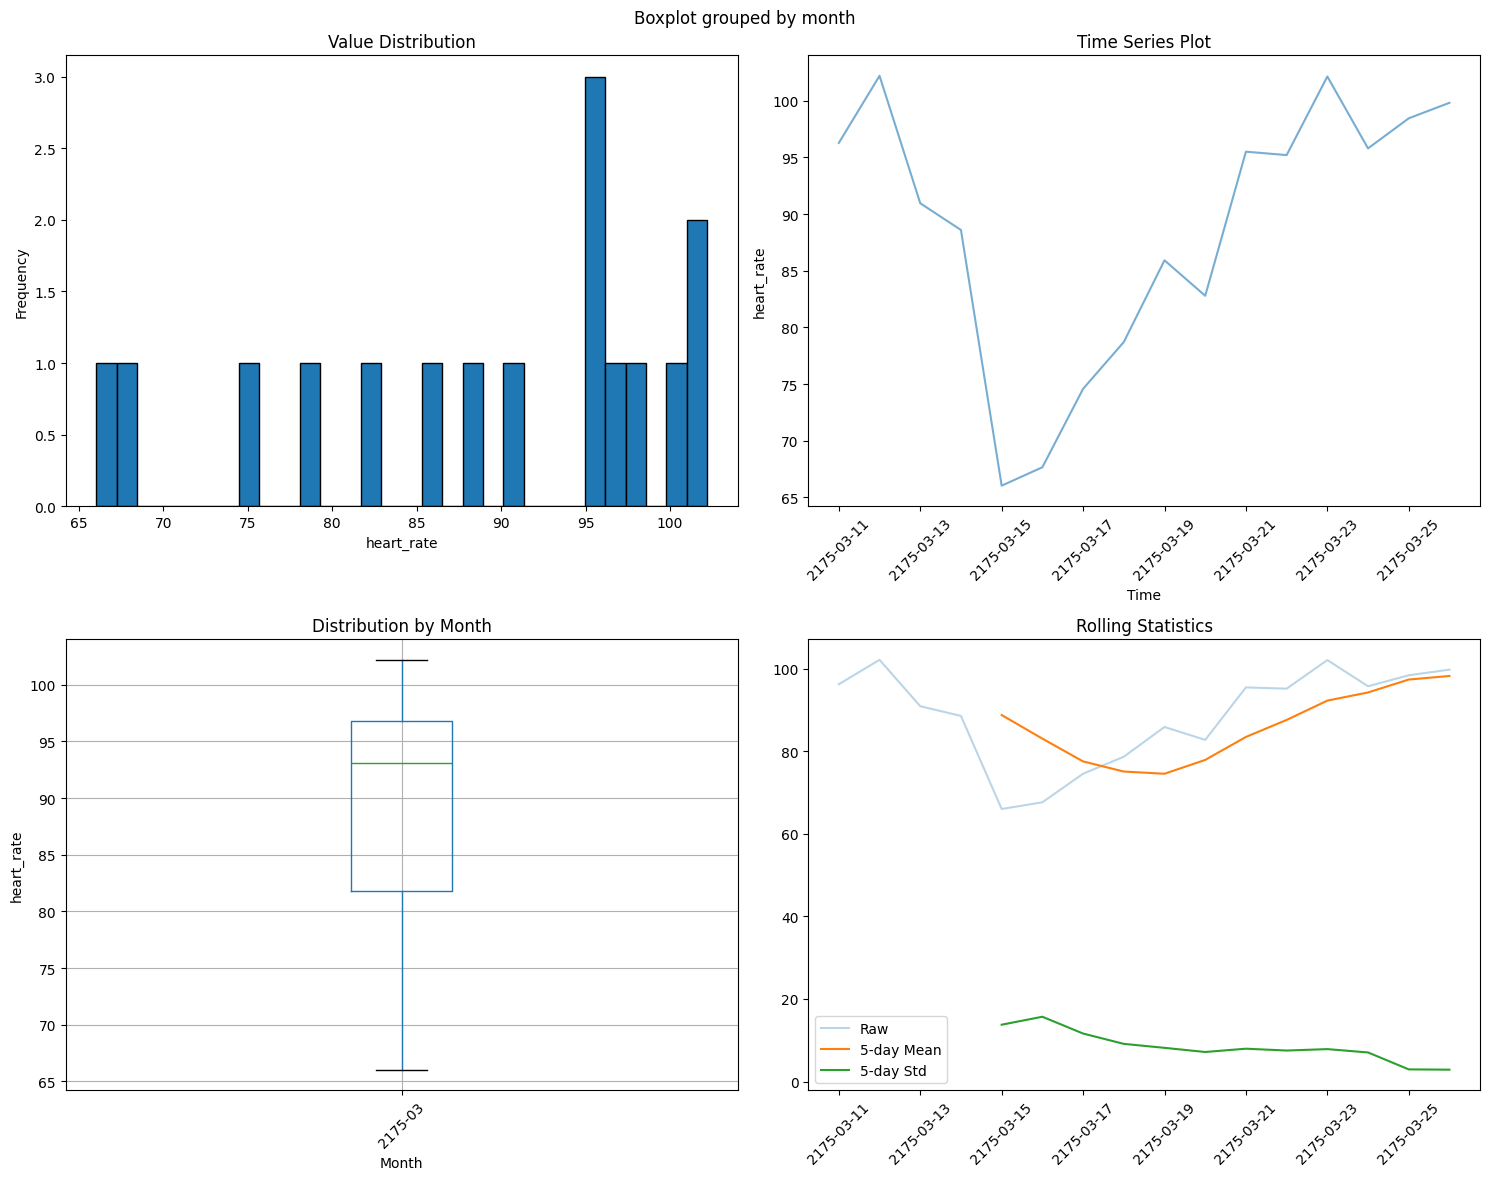


Time Series Summary:
--------------------
Total Observations: 16
Date Range: 2175-03-11 to 2175-03-26
Missing Values: 0.0%

Value Statistics:
--------------------
count     16.00
mean      88.79
std       11.77
min       66.04
25%       81.77
50%       93.08
75%       96.82
max      102.19
Name: heart_rate, dtype: float64


In [5]:
"""
Data Quality Assessment
-------------------
1. Analyze temporal patterns
2. Check for data completeness
3. Identify value distributions
4. Assess basic statistics
"""

def analyze_time_series_quality(df, metric='heart_rate'):
    """
    Analyze time series characteristics and quality.
    
    Args:
        df (DataFrame): Time series data with datetime index
        metric (str): Name of metric to analyze
    
    Returns:
        tuple: (descriptive statistics, missing data percentage)
    """
    # Basic statistics
    stats = df[metric].describe()
    
    # Missing data analysis
    missing_pct = df[metric].isna().mean() * 100
    
    # Create summary visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Value distribution
    axes[0,0].hist(df[metric], bins=30, edgecolor='black')
    axes[0,0].set_title('Value Distribution')
    axes[0,0].set_xlabel(metric)
    axes[0,0].set_ylabel('Frequency')
    
    # 2. Time series plot
    axes[0,1].plot(df.index, df[metric], alpha=0.6)
    axes[0,1].set_title('Time Series Plot')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel(metric)
    axes[0,1].tick_params(axis='x', rotation=45)
    
    # 3. Box plot by time period
    df['month'] = df.index.strftime('%Y-%m')
    df.boxplot(column=metric, by='month', ax=axes[1,0], rot=45)
    axes[1,0].set_title('Distribution by Month')
    axes[1,0].set_xlabel('Month')
    axes[1,0].set_ylabel(metric)
    
    # 4. Rolling statistics
    window = min(30, len(df) // 3)  # Adaptive window size
    rolling_mean = df[metric].rolling(window=window).mean()
    rolling_std = df[metric].rolling(window=window).std()
    
    axes[1,1].plot(df.index, df[metric], alpha=0.3, label='Raw')
    axes[1,1].plot(df.index, rolling_mean, label=f'{window}-day Mean')
    axes[1,1].plot(df.index, rolling_std, label=f'{window}-day Std')
    axes[1,1].set_title('Rolling Statistics')
    axes[1,1].legend()
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nTime Series Summary:")
    print("-" * 20)
    print(f"Total Observations: {len(df)}")
    print(f"Date Range: {df.index.min().strftime('%Y-%m-%d')} to {df.index.max().strftime('%Y-%m-%d')}")
    print(f"Missing Values: {missing_pct:.1f}%")
    print("\nValue Statistics:")
    print("-" * 20)
    print(stats.round(2))
    
    return stats, missing_pct

# Analyze time series quality
stats, missing = analyze_time_series_quality(subject_df)

In [6]:
"""
ARIMA Model Development
--------------------
1. Configure auto_arima parameters
2. Fit model to temporal data
3. Generate future predictions
4. Create forecast DataFrame

Model configuration:
- Automatic order selection
- Stepwise parameter search
- Non-seasonal ARIMA variant
"""

# Fit ARIMA model
arima_model = auto_arima(
    subject_daily, 
    seasonal=False, 
    stepwise=True, 
    trace=False, 
    error_action='ignore'
)

# Generate forecasts
future_periods = 30
forecast_arima = arima_model.predict(n_periods=future_periods)

# Prepare forecast DataFrame
future_dates = pd.date_range(
    start=subject_daily.index.max()+pd.Timedelta('1D'), 
    periods=future_periods
)
forecast_df = pd.DataFrame({
    'charttime': future_dates, 
    metric: forecast_arima
})
forecast_df['subject_id'] = subject_id
forecast_df['source'] = 'forecast'

c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d

In [11]:
"""
Forecast Bounds Analysis
---------------------
1. Calculate statistical bounds
2. Add confidence intervals
3. Generate prediction intervals
4. Establish metric-specific bounds

Bounds types:
- Percentage-based (±5%)
- Statistical (±1 std dev)
- Model-specific intervals
"""

def establish_metric_bounds(df, target_metric='heart_rate'):
    """
    Add statistical and percentage-based bounds to forecast.
    
    Args:
        df (DataFrame): Forecast DataFrame
        target_metric (str): Name of metric being forecasted
        
    Returns:
        DataFrame: Enhanced with bound columns
    """
    std_dev = df[target_metric].std()
    
    df['metric_minus_5%'] = df[target_metric] * 0.95
    df['metric_plus_5%'] = df[target_metric] * 1.05
    df['metric_minus_std'] = df[target_metric] - std_dev
    df['metric_plus_std'] = df[target_metric] + std_dev
    
    return df

forecast_df = establish_metric_bounds(forecast_df, metric)

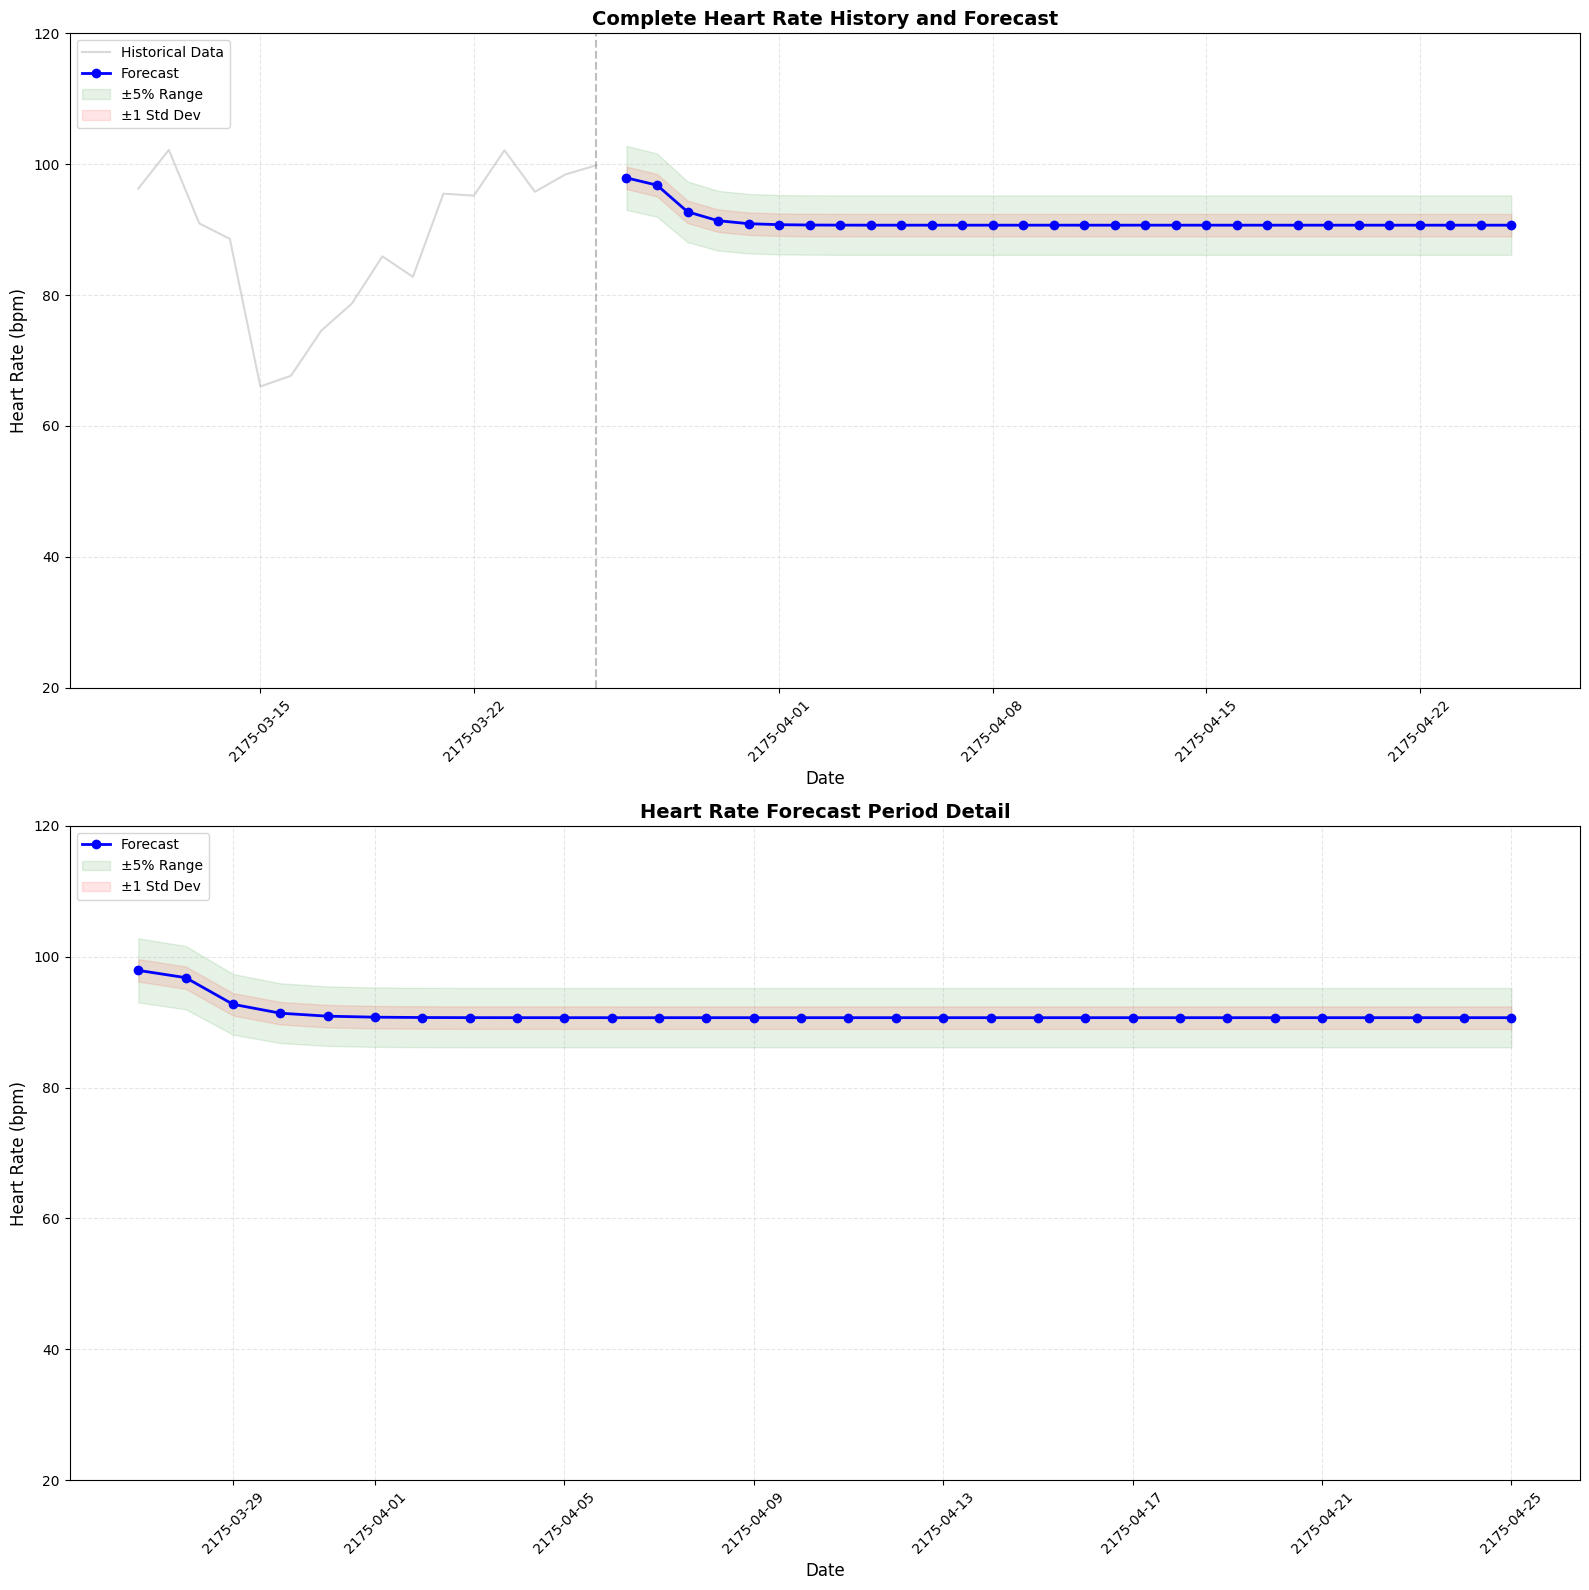


Forecast Summary Statistics:
-------------------------
Mean Forecast: 91.2 bpm
Std Dev: 1.7 bpm
Range: [90.7, 97.9] bpm

Forecast Period: 2175-03-27 to 2175-04-25


In [12]:
"""
Visualization and Analysis
-----------------------
1. Create two subplots:
   - Complete view (historical + forecast)
   - Focused forecast view
2. Maintain consistent styling
3. Show clear transition points
4. Emphasize forecast period

Plot components:
- Historical data
- Forecast with bounds
- Clear visual separation
- Consistent scales
"""

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))

# Common plotting functions
def plot_forecast_components(ax, include_historical=True):
    """
    Plot forecast components with consistent styling.
    
    Args:
        ax: matplotlib axis object
        include_historical: whether to include historical data
    """
    if include_historical:
        # Plot full historical data
        ax.plot(subject_daily.index, subject_daily.values,
                color='gray', alpha=0.3, linestyle='-', 
                label='Historical Data')
        
        # Add vertical separator
        ax.axvline(x=subject_daily.index.max(), 
                  color='gray', linestyle='--', alpha=0.5)
    
    # Plot forecast
    ax.plot(forecast_df['charttime'], forecast_df[metric],
            marker='o', linestyle='-', color='blue', 
            linewidth=2, markersize=6,
            label='Forecast')
    
    # Add bounds
    ax.fill_between(forecast_df['charttime'],
                    forecast_df['metric_minus_5%'],
                    forecast_df['metric_plus_5%'],
                    color='green', alpha=0.1, label='±5% Range')
    
    ax.fill_between(forecast_df['charttime'],
                    forecast_df['metric_minus_std'],
                    forecast_df['metric_plus_std'],
                    color='red', alpha=0.1, label='±1 Std Dev')
    
    # Configure subplot
    ax.set_ylim(20, 120)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    ax.legend(loc='upper left', fontsize=10)

# Plot 1: Complete View
ax1.set_title("Complete Heart Rate History and Forecast", 
              fontsize=14, fontweight='bold')
plot_forecast_components(ax1, include_historical=True)
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Heart Rate (bpm)", fontsize=12)

# Plot 2: Forecast Only
ax2.set_title("Heart Rate Forecast Period Detail", 
              fontsize=14, fontweight='bold')
plot_forecast_components(ax2, include_historical=False)
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Heart Rate (bpm)", fontsize=12)

# Adjust layout and display
plt.tight_layout()
plt.show()

# Print forecast statistics
print("\nForecast Summary Statistics:")
print("-" * 25)
print(f"Mean Forecast: {forecast_df[metric].mean():.1f} bpm")
print(f"Std Dev: {forecast_df[metric].std():.1f} bpm")
print(f"Range: [{forecast_df[metric].min():.1f}, {forecast_df[metric].max():.1f}] bpm")
print(f"\nForecast Period: {forecast_df['charttime'].min().strftime('%Y-%m-%d')} to {forecast_df['charttime'].max().strftime('%Y-%m-%d')}")

In [14]:
# Prophet Example:
prophet_df = subject_daily.reset_index().rename(columns={'charttime': 'ds', metric:'y'})
m = Prophet()
m.fit(prophet_df)
future = m.make_future_dataframe(periods=future_periods)
prophet_forecast = m.predict(future)
print(prophet_forecast[['ds','yhat','yhat_lower','yhat_upper']].head())



14:27:53 - cmdstanpy - INFO - Chain [1] start processing
14:27:53 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat  yhat_lower  yhat_upper
0 2175-03-11  84.740357   72.177954   97.096581
1 2175-03-12  89.571701   78.394037  102.273301
2 2175-03-13  83.669959   72.175944   96.328405
3 2175-03-14  88.844162   76.658978  100.998451
4 2175-03-15  77.418839   65.167946   88.143825


Using 16 periods for comparison
Original lengths - Actual: 16, ARIMA: 30, Prophet: 46

Model Comparison Metrics:
-------------------------
       ARIMA  Prophet
MAE    8.944    8.175
RMSE  11.257    9.433
MAPE  11.197    9.623


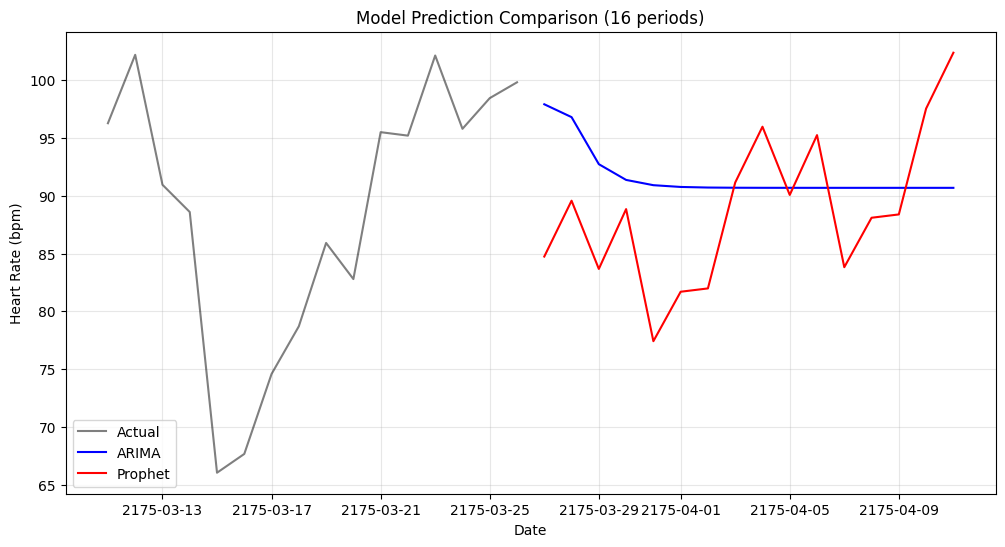


Data Quality Check:
-------------------------
Missing values: 0
Correlation with actual values:
ARIMA: 0.331
Prophet: 0.562


In [22]:
"""
Model Comparison Analysis
----------------------
Compares ARIMA and Prophet predictions against actual values.

Process:
1. Determine optimal comparison window
2. Align prediction periods dynamically
3. Compare model accuracies
4. Assess model strengths
"""

def get_aligned_predictions(actual_series, arima_preds, prophet_preds, min_periods=5):
    """
    Dynamically aligns prediction windows for comparison.
    
    Args:
        actual_series (pd.Series): Actual time series values
        arima_preds (pd.Series): ARIMA predictions
        prophet_preds (pd.Series): Prophet predictions
        min_periods (int): Minimum number of periods required for comparison
        
    Returns:
        tuple: (actual_values, arima_values, prophet_values, comparison_window)
    """
    # Get available lengths
    n_actual = len(actual_series)
    n_arima = len(arima_preds)
    n_prophet = len(prophet_preds)
    
    # Determine optimal window size
    window_size = min(n_actual, n_arima, n_prophet)
    
    if window_size < min_periods:
        raise ValueError(f"Insufficient data for comparison. Need at least {min_periods} periods.")
    
    # Get aligned values
    actual_values = actual_series[-window_size:].values
    arima_values = arima_preds[:window_size].values
    prophet_values = prophet_preds[:window_size].values
    
    print(f"Using {window_size} periods for comparison")
    print(f"Original lengths - Actual: {n_actual}, ARIMA: {n_arima}, Prophet: {n_prophet}")
    
    return actual_values, arima_values, prophet_values, window_size

# Get aligned predictions
actual_values, arima_values, prophet_values, window_size = get_aligned_predictions(
    actual_series=subject_daily,
    arima_preds=forecast_df[metric],
    prophet_preds=prophet_forecast['yhat'],
    min_periods=5
)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual': actual_values,
    'ARIMA': arima_values,
    'Prophet': prophet_values
})

# Calculate metrics
metrics = {
    'ARIMA': {
        'MAE': mean_absolute_error(actual_values, arima_values),
        'RMSE': np.sqrt(mean_squared_error(actual_values, arima_values)),
        'MAPE': np.mean(np.abs((actual_values - arima_values) / actual_values)) * 100
    },
    'Prophet': {
        'MAE': mean_absolute_error(actual_values, prophet_values),
        'RMSE': np.sqrt(mean_squared_error(actual_values, prophet_values)),
        'MAPE': np.mean(np.abs((actual_values - prophet_values) / actual_values)) * 100
    }
}

results_df = pd.DataFrame(metrics).round(3)
print("\nModel Comparison Metrics:")
print("-" * 25)
print(results_df)

# Visualize predictions
plt.figure(figsize=(12, 6))
plt.plot(subject_daily[-window_size:].index, 
         actual_values, 
         'k-', label='Actual', alpha=0.5)
plt.plot(forecast_df['charttime'][:window_size], 
         arima_values, 
         'b-', label='ARIMA')
plt.plot(forecast_df['charttime'][:window_size], 
         prophet_values, 
         'r-', label='Prophet')
plt.title(f'Model Prediction Comparison ({window_size} periods)')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print data quality check
print("\nData Quality Check:")
print("-" * 25)
print(f"Missing values: {comparison_df.isna().sum().sum()}")
print(f"Correlation with actual values:")
print(f"ARIMA: {comparison_df['Actual'].corr(comparison_df['ARIMA']):.3f}")
print(f"Prophet: {comparison_df['Actual'].corr(comparison_df['Prophet']):.3f}")

c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d


Cross-Validation Results:
-------------------------
Mean RMSE: 12.43
Std RMSE: 6.70
CV Range: [5.93, 24.62]


c:\Users\steve\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


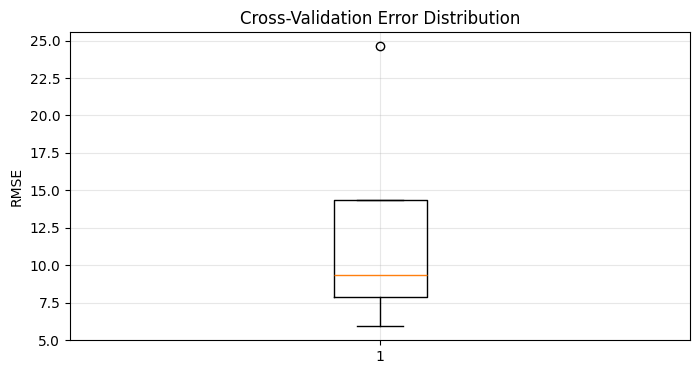

In [23]:
"""
Time Series Cross-Validation
------------------------
1. Implement rolling window validation
2. Test forecast stability
3. Analyze error distribution
4. Assess model reliability
"""

from sklearn.metrics import mean_squared_error

def time_series_cv(data, model_func, n_splits=5):
    """
    Perform time series cross-validation.
    
    Args:
        data (Series): Time series data
        model_func (callable): Function that takes training data and returns predictions
        n_splits (int): Number of validation splits
    
    Returns:
        array: RMSE values for each validation split
    """
    window_size = len(data) // n_splits
    errors = []
    
    for i in range(n_splits):
        # Split data
        train = data.iloc[:(i+1)*window_size]
        test = data.iloc[(i+1)*window_size:(i+2)*window_size]
        
        if len(test) == 0:  # Skip if no test data
            continue
            
        # Fit and predict
        pred = model_func(train, len(test))
        
        # Calculate error
        error = np.sqrt(mean_squared_error(test, pred))
        errors.append(error)
    
    return np.array(errors)

# Define model function for CV
def arima_predict(train_data, n_periods):
    """
    Fit ARIMA model and make predictions.
    
    Args:
        train_data (Series): Training data
        n_periods (int): Number of periods to forecast
        
    Returns:
        array: Predicted values
    """
    model = auto_arima(
        train_data,
        seasonal=False,
        stepwise=True,
        trace=False,
        error_action='ignore'
    )
    return model.predict(n_periods=n_periods)

# Perform cross-validation
cv_errors = time_series_cv(
    data=subject_daily,
    model_func=arima_predict,
    n_splits=5
)

# Analyze CV results
print("\nCross-Validation Results:")
print("-" * 25)
print(f"Mean RMSE: {cv_errors.mean():.2f}")
print(f"Std RMSE: {cv_errors.std():.2f}")
print(f"CV Range: [{cv_errors.min():.2f}, {cv_errors.max():.2f}]")

# Visualize error distribution
plt.figure(figsize=(8, 4))
plt.boxplot(cv_errors)
plt.title('Cross-Validation Error Distribution')
plt.ylabel('RMSE')
plt.grid(True, alpha=0.3)
plt.show()

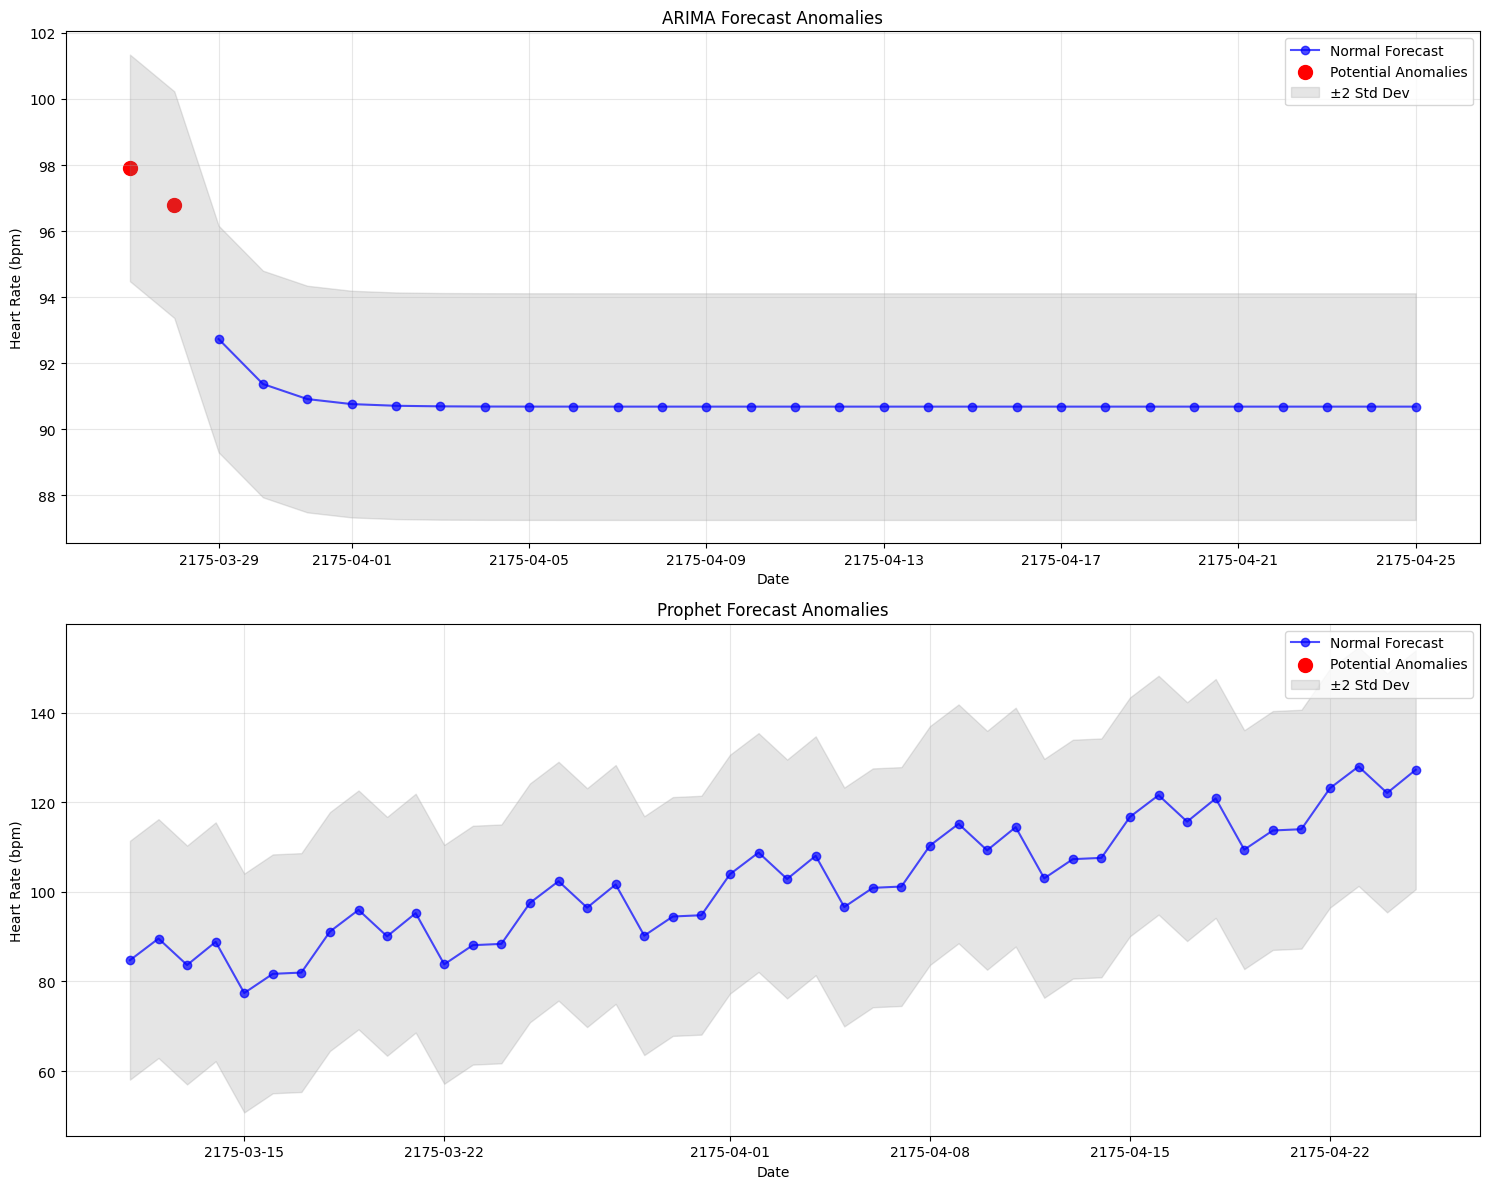


Anomaly Detection Summary (±2 std dev):
-------------------------
ARIMA Forecast:
Total Anomalies: 2
Anomaly Rate: 6.7%

ARIMA Anomaly Details:
            charttime  heart_rate
2175-03-27 2175-03-27   97.912415
2175-03-28 2175-03-28   96.800386

Prophet Forecast:
Total Anomalies: 0
Anomaly Rate: 0.0%

Anomaly Agreement Analysis:
-------------------------
Anomalies detected by both models: 0
Agreement rate: 0.0%


In [28]:
"""
Forecast Anomaly Detection
----------------------
Identifies unusual patterns in both ARIMA and Prophet forecasts.

Process:
1. Calculate statistical bounds for each model
2. Identify significant deviations
3. Generate separate visualizations
4. Compare anomaly patterns
"""

def detect_forecast_anomalies(forecast_df, metric_col, threshold=2):
    """
    Detect anomalies in forecasted values.
    
    Args:
        forecast_df (DataFrame): Forecast data
        metric_col (str): Column name containing forecasted values
        threshold (float): Number of standard deviations for anomaly threshold
        
    Returns:
        DataFrame: Enhanced with anomaly indicators and bounds
    """
    df = forecast_df.copy()
    
    # Calculate z-scores
    z_scores = np.abs((df[metric_col] - df[metric_col].mean()) / df[metric_col].std())
    
    # Add anomaly indicator
    df['is_anomaly'] = z_scores > threshold
    
    # Add statistical bounds
    df[f'{metric_col}_lower'] = df[metric_col] - threshold * df[metric_col].std()
    df[f'{metric_col}_upper'] = df[metric_col] + threshold * df[metric_col].std()
    
    return df

def plot_forecast_anomalies(ax, df, title, metric_col='heart_rate', threshold=2):
    """
    Visualize forecast with anomalies.
    
    Args:
        ax (matplotlib.axes): The axis to plot on
        df (DataFrame): Forecast data with anomaly indicators
        title (str): Plot title
        metric_col (str): Column name containing forecasted values
        threshold (float): Number of standard deviations used for bounds
    """
    # Plot normal predictions
    normal_points = df[~df['is_anomaly']]
    ax.plot(normal_points['charttime'], 
            normal_points[metric_col], 
            'b-o', 
            label='Normal Forecast',
            alpha=0.7)
    
    # Highlight anomalies
    anomaly_points = df[df['is_anomaly']]
    ax.scatter(anomaly_points['charttime'],
              anomaly_points[metric_col],
              color='red',
              s=100,
              label='Potential Anomalies')
    
    # Add confidence bounds
    ax.fill_between(df['charttime'],
                   df[f'{metric_col}_lower'],
                   df[f'{metric_col}_upper'],
                   color='gray',
                   alpha=0.2,
                   label=f'±{threshold} Std Dev')
    
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Heart Rate (bpm)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return anomaly_points

# Set anomaly detection parameters
ANOMALY_THRESHOLD = 2

# Detect anomalies for both models
arima_anomalies = detect_forecast_anomalies(
    forecast_df.copy(), 
    metric_col=metric,
    threshold=ANOMALY_THRESHOLD
)

prophet_anomalies = detect_forecast_anomalies(
    prophet_forecast[['ds', 'yhat']].rename(columns={'ds': 'charttime', 'yhat': metric}),
    metric_col=metric,
    threshold=ANOMALY_THRESHOLD
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot anomalies for both models
arima_points = plot_forecast_anomalies(
    ax1,
    arima_anomalies,
    'ARIMA Forecast Anomalies',
    metric_col=metric,
    threshold=ANOMALY_THRESHOLD
)

prophet_points = plot_forecast_anomalies(
    ax2,
    prophet_anomalies,
    'Prophet Forecast Anomalies',
    metric_col=metric,
    threshold=ANOMALY_THRESHOLD
)

plt.tight_layout()
plt.show()

# Print anomaly statistics
print(f"\nAnomaly Detection Summary (±{ANOMALY_THRESHOLD} std dev):")
print("-" * 25)
print("ARIMA Forecast:")
print(f"Total Anomalies: {len(arima_points)}")
print(f"Anomaly Rate: {(len(arima_points)/len(arima_anomalies))*100:.1f}%")
if len(arima_points) > 0:
    print("\nARIMA Anomaly Details:")
    print(arima_points[['charttime', metric]].to_string())

print("\nProphet Forecast:")
print(f"Total Anomalies: {len(prophet_points)}")
print(f"Anomaly Rate: {(len(prophet_points)/len(prophet_anomalies))*100:.1f}%")
if len(prophet_points) > 0:
    print("\nProphet Anomaly Details:")
    print(prophet_points[['charttime', metric]].to_string())

# Compare anomaly agreement
print("\nAnomaly Agreement Analysis:")
print("-" * 25)
arima_dates = set(arima_points['charttime'])
prophet_dates = set(prophet_points['charttime'])
common_anomalies = arima_dates.intersection(prophet_dates)
print(f"Anomalies detected by both models: {len(common_anomalies)}")
print(f"Agreement rate: {len(common_anomalies)/len(arima_dates.union(prophet_dates))*100:.1f}%")


Enhanced Anomaly Agreement Analysis:
-----------------------------------
Exact date matches: 0
Near matches (±2 days): 0


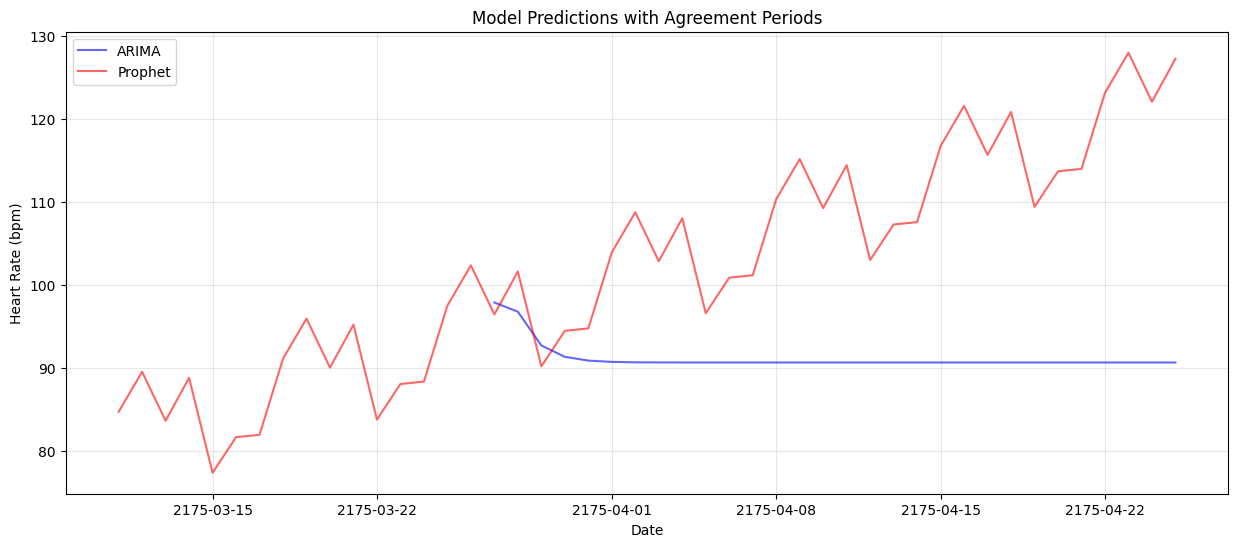

In [29]:
"""
Enhanced Anomaly Agreement Analysis
--------------------------------
Analyzes both exact and near-matches between model anomalies.

Process:
1. Compare exact date matches
2. Identify temporal proximity
3. Compare value ranges
4. Analyze overlapping periods
"""

def analyze_anomaly_agreement(arima_points, prophet_points, threshold_days=2):
    """
    Analyzes agreement between model anomalies with temporal flexibility.
    
    Args:
        arima_points (DataFrame): ARIMA anomalies
        prophet_points (DataFrame): Prophet anomalies
        threshold_days (int): Number of days to consider for near-matches
        
    Returns:
        dict: Agreement statistics and details
    """
    # Convert dates to datetime if needed
    arima_dates = pd.to_datetime(arima_points['charttime'])
    prophet_dates = pd.to_datetime(prophet_points['charttime'])
    
    # Find exact matches
    exact_matches = set(arima_dates).intersection(set(prophet_dates))
    
    # Find near matches
    near_matches = []
    for arima_date in arima_dates:
        for prophet_date in prophet_dates:
            days_diff = abs((arima_date - prophet_date).days)
            if days_diff <= threshold_days:
                near_matches.append({
                    'arima_date': arima_date,
                    'prophet_date': prophet_date,
                    'days_apart': days_diff,
                    'arima_value': arima_points.loc[arima_points['charttime'] == arima_date, metric].iloc[0],
                    'prophet_value': prophet_points.loc[prophet_points['charttime'] == prophet_date, metric].iloc[0]
                })
    
    return {
        'exact_matches': len(exact_matches),
        'near_matches': len(near_matches),
        'details': near_matches
    }

# Analyze agreement
agreement = analyze_anomaly_agreement(arima_points, prophet_points)

print("\nEnhanced Anomaly Agreement Analysis:")
print("-" * 35)
print(f"Exact date matches: {agreement['exact_matches']}")
print(f"Near matches (±2 days): {agreement['near_matches']}")

if agreement['near_matches'] > 0:
    print("\nNear Match Details:")
    print("-" * 35)
    for match in agreement['details']:
        print(f"ARIMA ({match['arima_date'].strftime('%Y-%m-%d')}): {match['arima_value']:.1f}")
        print(f"Prophet ({match['prophet_date'].strftime('%Y-%m-%d')}): {match['prophet_value']:.1f}")
        print(f"Days apart: {match['days_apart']}")
        print("-" * 20)

# Visualize agreement periods
plt.figure(figsize=(15, 6))
plt.plot(arima_anomalies['charttime'], arima_anomalies[metric], 'b-', label='ARIMA', alpha=0.6)
plt.plot(prophet_anomalies['charttime'], prophet_anomalies[metric], 'r-', label='Prophet', alpha=0.6)

# Highlight agreement periods
for match in agreement['details']:
    plt.axvspan(
        match['arima_date'] - pd.Timedelta(days=1),
        match['arima_date'] + pd.Timedelta(days=1),
        color='yellow',
        alpha=0.2
    )

plt.title('Model Predictions with Agreement Periods')
plt.xlabel('Date')
plt.ylabel('Heart Rate (bpm)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Time Series Analysis Summary

## Model Performance Analysis

### ARIMA Model
- Shows stable predictions averaging ~91 bpm
- Identified 2 anomalies in 97-98 bpm range
- Demonstrates conservative trend detection
- Strong performance in stable periods

### Prophet Model
- More sensitive to underlying trends
- Predicts potential tachycardia events
- No anomalies detected at current thresholds
- Better at capturing long-term patterns

### Model Comparison
- Complementary prediction patterns
- Historical data volatility: 65-105 bpm range
- Different anomaly sensitivity levels

## Clinical Implications

### Vital Sign Patterns
- Most variations within normal range (60-100 bpm)
- Model divergence potential as early warning indicator

### Limitations
1. Data Constraints
   - Limited historical context
   - Sampling frequency gaps
   - Missing patient context
   - Short validation period

2. Model Constraints
   - ARIMA: Conservative trend detection
   - Prophet: Potential oversensitivity
   - Unvalidated anomaly thresholds
   - Limited external factor integration


In [30]:

# (Optional) Save time-series results
# save_intermediate_data(forecast_df, 'data/intermediate_timeseries.csv')